In [47]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from scipy.stats import skew, boxcox,zscore
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [48]:
class CFG:
    target = "Calories"
    target_means = "Calories_mean"
    target_per_duration = "Calories_Per_Duration"
    target_vars = [target,target_means,target_per_duration]
    n_folds = 50
    seed = 42
    folder_path = 'playground-series-s5e5_csv/'

In [49]:
train = pd.read_csv(CFG.folder_path + 'train.csv')
test = pd.read_csv(CFG.folder_path + '/test.csv')
test['Calories'] = 0
train['is_train'] = 1
test['is_train'] = 0
gender_map = {'male':1,'female':0}
datamart = pd.concat((train,test)).reset_index(drop=True)
datamart['Sex'] = datamart['Sex'].map(gender_map)

# 1 Data overview

In [50]:
# There are no missing values.
# Height min is 126...????
datamart.describe()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,is_train
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,0.498998,41.428419,174.704670,75.146179,15.419618,95.482767,40.036213,66.212086,0.750000
std,288675.278932,0.499999,15.175728,12.823881,13.981899,8.352851,9.449920,0.779518,66.190875,0.433013
min,0.000000,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,0.000000,0.000000
25%,249999.750000,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,0.750000,0.750000
50%,499999.500000,0.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,47.000000,1.000000
75%,749999.250000,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,113.000000,1.000000
max,999999.000000,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,1.000000


In [51]:
# There are records where only the value of the target variable differs while all other values remain the same.
def find_rows_differ_only_in(df, target_col):
    other_cols = [col for col in df.columns if col != target_col]
    grouped = df.groupby(other_cols)

    result_groups = [group for _, group in grouped if group[target_col].nunique() > 1]
    
    if result_groups:
        return pd.concat(result_groups).drop_duplicates()
    else:
        return pd.DataFrame()  

find_rows_differ_only_in(datamart[datamart['is_train'] == 1].drop(['id','is_train'],axis=1),'Calories')

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
75584,0,20,149.0,54.0,27.0,104.0,40.7,162.0
576877,0,20,149.0,54.0,27.0,104.0,40.7,156.0
35106,0,20,151.0,54.0,19.0,96.0,40.6,94.0
547537,0,20,151.0,54.0,19.0,96.0,40.6,99.0
94676,0,20,152.0,54.0,14.0,96.0,40.2,70.0
...,...,...,...,...,...,...,...,...
596683,1,76,189.0,93.0,29.0,112.0,40.8,259.0
597456,1,78,174.0,77.0,24.0,107.0,40.7,202.0
741535,1,78,174.0,77.0,24.0,107.0,40.7,204.0
728500,1,79,182.0,83.0,26.0,110.0,40.8,241.0


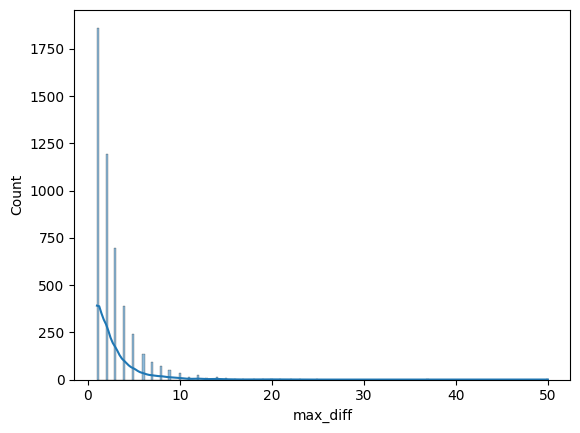

In [52]:
def max_difference_per_duplicate_group(df, target_col):
    other_cols = [col for col in df.columns if col != target_col]
    diff_df = (
        df.groupby(other_cols)[target_col]
        .agg(['min', 'max'])
        .reset_index()
    )
    diff_df['max_diff'] = diff_df['max'] - diff_df['min']
    return diff_df[diff_df['max_diff'] > 0]
max_difference_per_duplicate_group(datamart[datamart['is_train'] == 1].drop(['id','is_train'],axis=1),'Calories').sort_values(by = 'max_diff')
sns.histplot(max_difference_per_duplicate_group(datamart[datamart['is_train'] == 1].drop(['id','is_train'],axis=1),'Calories')['max_diff'], kde=True)
# This level of difference can be considered as a simple measurement error, 
# so I’ve decided to replace the calorie values with the average value when all other variables are identical.
group_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

datamart['Calories_means'] = datamart.groupby(group_cols)['Calories'].transform('mean')

Skewness: 6.774017401284832


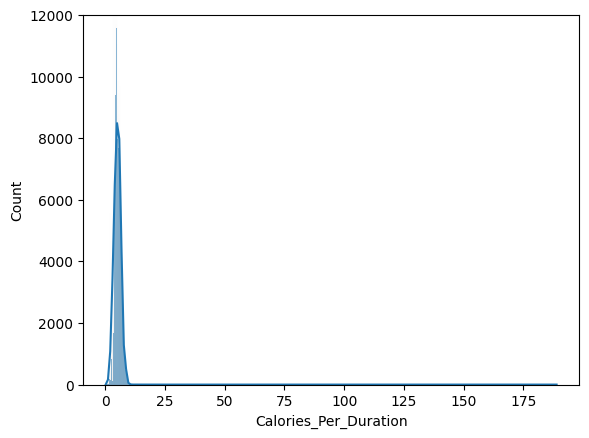

In [53]:
# Since calorie consumption is affected by exercise duration, 
# calculating calories burned per minute may result in a distribution that is more normalized.

datamart['Calories_Per_Duration'] = datamart['Calories_means']/datamart['Duration']
print("Skewness:", skew(datamart[datamart['is_train'] == 1]['Calories_Per_Duration']))
sns.histplot(datamart[datamart['is_train'] == 1]['Calories_Per_Duration'], kde=True)
plt.ylim(0, 12000)
plt.show()


In [54]:
# https://l.myzone.org/b2b/how-does-myzone-calculate-calorie-burn
# Estimate calorie consumption based on heart rate, body weight, and age, then compare it with the actual consumption.

# MET_male:    C/min = ((0.6309 * HR) + (0.1988 * weight_kg) + (0.2017 * age) - 55.0969) / 4.184
# MET_female:  C/min = ((0.4472 * HR) + (0.1263 * weight_kg) + (0.074 * age) - 20.4022) / 4.184
# = (((0.4472 + Sex * 0.1837) * HR) + ((0.1263 + Sex *0.725) * weight) + ((0.074 + Sex * 0.1277) * Age) - (20.4022 + Sex * 34.6947)) / 4.184
datamart['MET'] = (
    ((0.4472 + datamart['Sex'] * 0.1837) * datamart['Heart_Rate']) +
    ((0.1263 + datamart['Sex'] * 0.0725) * datamart['Weight']) +
    ((0.074  + datamart['Sex'] * 0.1277) * datamart['Age']) -
    (20.4022 + datamart['Sex'] * 34.6947)
) / 4.184

# Calculate heart rate percentage based on HRmax
# Heart_Rate/(220-Age) * 100
# 50–60% HRmax: Light exercise (e.g., walking)
# 70–80% HRmax: Aerobic endurance training
# 85–95% HRmax: High-intensity interval training (HIIT)

datamart['Heart_Rate_hrmax'] = datamart['Heart_Rate']/(220-datamart['Age']) * 100

# Mifflin-St Jeor BMR calculation method
# for Man   : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)+5
# for Woman : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)−161

datamart['BMR'] = datamart['Weight'] * 10 + datamart['Height'] * 6.25 - datamart['Age'] * 5 - datamart['Sex'] * 166 - 161

# BMI weight/height(m)^2

datamart['BMI'] = datamart['Weight'] / (datamart['Height']/100)**2

Skewness Z_Score1: -0.5118806545560632
Count Rows :0.823
Skewness Z_Score2: 0.003168483066361815
Count Rows :0.995
Skewness Z_Score3: 0.095931430400836
Count Rows :1.000


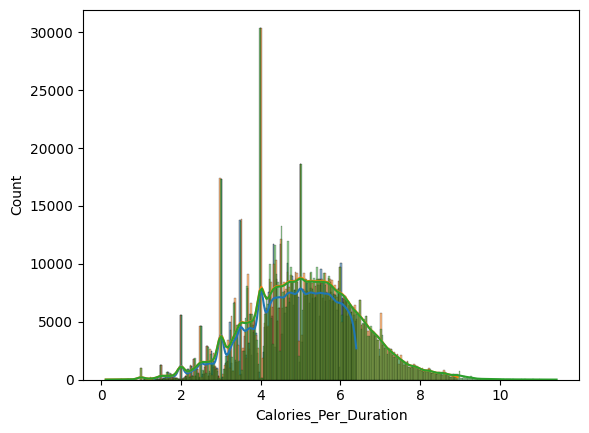

In [55]:
datamart['Z_Score'] = zscore(datamart['Calories_Per_Duration'])
for i in range(1,4):
    datamart_filtered = datamart[(datamart['is_train'] == 1) & (datamart['Z_Score'].abs() < i)] 
    print(f"Skewness Z_Score{i}:", skew(datamart_filtered['Calories_Per_Duration']))
    print(f"Count Rows :{len(datamart_filtered)/len(train):.3f}")
    sns.histplot(datamart_filtered['Calories_Per_Duration'], kde=True)

# It seems better to filter Z_score under 2

In [56]:
train_filtered = datamart[(datamart['is_train'] == 1) & (datamart['Z_Score'].abs() < 2)].copy()
train_filtered.drop(columns=['Z_Score'], inplace=True)
train_filtered

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,is_train,Calories_means,Calories_Per_Duration,MET,Heart_Rate_hrmax,BMR,BMI
0,0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,1,150.0,5.769231,7.692830,54.891304,1494.25,22.955684
1,1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,1,34.0,4.250000,7.151960,54.487179,1137.75,22.582709
2,2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,1,29.0,4.142857,6.935899,49.704142,1230.25,24.690405
3,3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,1,138.5,5.540000,7.904780,52.500000,1673.00,24.414062
4,4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,1,146.0,5.840000,8.539316,56.043956,1296.50,22.136740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,1,28,193.0,97.0,30.0,114.0,40.9,230.0,1,230.0,7.666667,9.980139,59.375000,1709.25,26.040968
749996,749996,0,64,165.0,63.0,18.0,92.0,40.5,96.0,1,96.0,5.333333,7.990703,58.974359,1180.25,23.140496
749997,749997,1,60,162.0,67.0,29.0,113.0,40.9,221.0,1,221.0,7.620690,9.946558,70.625000,1055.50,25.529645
749998,749998,1,45,182.0,91.0,17.0,102.0,40.3,109.0,1,109.0,6.411765,8.705115,58.285714,1495.50,27.472527


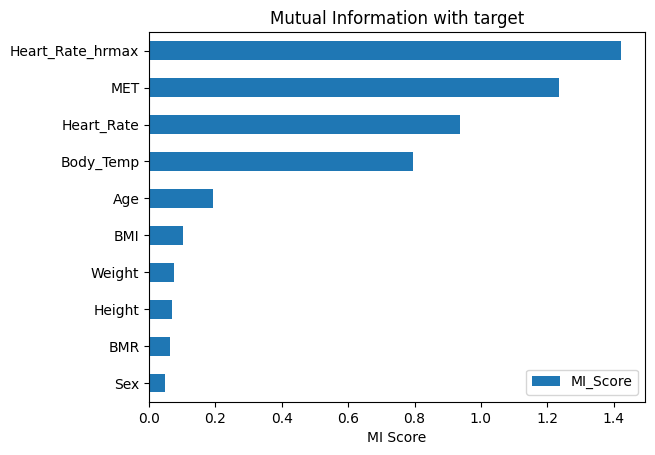

In [57]:
X = train_filtered.drop(columns=["id","is_train","Calories","Calories_Per_Duration","Calories_means","Duration"])
y = train_filtered["Calories_Per_Duration"] 
mi = mutual_info_regression(X, y,random_state=CFG.seed)
mi = pd.Series(mi)
mi.index = X.columns
pd_mi = pd.DataFrame(mi.sort_values(ascending=False), columns=['MI_Score'])
pd_mi.plot.barh(title="Mutual Information with target")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()

In [58]:
corr_data = train_filtered[['Sex','Age','Height','Weight','MET','BMI','BMR','Heart_Rate_hrmax','Heart_Rate','Body_Temp','Calories_Per_Duration']]
corr = corr_data.corr()
corr.style.background_gradient(cmap='coolwarm')

# Duration, Heart_rate ,Body_Temp(Body Temperature) has very high score

,Sex,Age,Height,Weight,MET,BMI,BMR,Heart_Rate_hrmax,Heart_Rate,Body_Temp,Calories_Per_Duration
Sex,1.000000,0.001688,0.755654,0.818166,-0.229899,0.681696,0.533329,-0.003385,0.000645,-0.020490,-0.029379
Age,0.001688,1.000000,0.004444,0.065274,0.364591,0.185473,-0.385083,0.666121,0.002215,0.022699,0.356141
Height,0.755654,0.004444,1.000000,0.957909,-0.057310,0.521503,0.877846,-0.017555,-0.022007,-0.039452,-0.023762
Weight,0.818166,0.065274,0.957909,1.000000,-0.042596,0.738993,0.835478,0.028909,-0.012648,-0.029315,0.008778
MET,-0.229899,0.364591,-0.057310,-0.042596,1.000000,-0.008160,-0.110399,0.866073,0.842223,0.686800,0.932020
BMI,0.681696,0.185473,0.521503,0.738993,-0.008160,1.000000,0.432907,0.128594,0.014292,0.003929,0.066639
BMR,0.533329,-0.385083,0.877846,0.835478,-0.110399,0.432907,1.000000,-0.275746,-0.021833,-0.042300,-0.146231
Heart_Rate_hrmax,-0.003385,0.666121,-0.017555,0.028909,0.866073,0.128594,-0.275746,1.000000,0.741572,0.602839,0.885335
Heart_Rate,0.000645,0.002215,-0.022007,-0.012648,0.842223,0.014292,-0.021833,0.741572,1.000000,0.796316,0.876189
Body_Temp,-0.020490,0.022699,-0.039452,-0.029315,0.686800,0.003929,-0.042300,0.602839,0.796316,1.000000,0.715061


In [59]:
def safe_rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [60]:
train_X = train_filtered.drop(columns=["id","is_train","Calories","Calories_Per_Duration","Calories_means","Duration"])
train_y = train_filtered["Calories_Per_Duration"] 

In [62]:
def create_objective(ModelClass, param_space_func):
    def objective(trial):
        params = param_space_func(trial)
        model = ModelClass(**params)
        try:
            scores = cross_val_score(
                model, train_X, train_y,
                scoring=lambda m, X, y: safe_rmsle(y, m.predict(X)),
                cv=KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed),
                n_jobs=-1
            )
            return np.mean(scores)
        except Exception as e:
            return float('inf')
    return objective


def lgbm_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": CFG.seed
    }


def catboost_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "random_seed": CFG.seed,
        "verbose": 0
    }


def xgb_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": CFG.seed
    }

def HGBR_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 5.0),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 500),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 100),
        "random_state": CFG.seed,
        "early_stopping": True,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10
    }


results = {}

for model_name, (ModelClass, param_func) in {
    "LGBM": (LGBMRegressor, lgbm_param_space),
    "CatBoost": (CatBoostRegressor, catboost_param_space),
    "XGBoost": (XGBRegressor, xgb_param_space),
    "HGBR": (HistGradientBoostingRegressor, HGBR_param_space)
}.items():
    print(f"🔍 {model_name} 튜닝 중...")
    study = optuna.create_study(direction="minimize")
    study.optimize(create_objective(ModelClass, param_func), n_trials=30)

    results[model_name] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
    }

# 📢 결과 비교
print("\n✅ 성능 비교 (RMSLE 기준):")
for name, result in results.items():
    print(f"{name}: RMSLE = {result['best_value']:.5f}")

[I 2025-05-15 16:30:03,157] A new study created in memory with name: no-name-931b23bd-d87f-4f63-b470-493802cd8ee1


🔍 LGBM 튜닝 중...


[I 2025-05-15 16:41:31,359] Trial 0 finished with value: 0.06441844401902529 and parameters: {'learning_rate': 0.015698730534464984, 'n_estimators': 690, 'num_leaves': 117, 'max_depth': 24, 'min_child_samples': 100, 'subsample': 0.5177985013748196, 'colsample_bytree': 0.7797434547294941}. Best is trial 0 with value: 0.06441844401902529.
[I 2025-05-15 16:44:04,141] Trial 1 finished with value: 0.0650372971680934 and parameters: {'learning_rate': 0.030237385011158285, 'n_estimators': 149, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 95, 'subsample': 0.5405882368758158, 'colsample_bytree': 0.6351461459557529}. Best is trial 0 with value: 0.06441844401902529.
[I 2025-05-15 16:55:49,443] Trial 2 finished with value: 0.06456716048783484 and parameters: {'learning_rate': 0.04148392344322521, 'n_estimators': 930, 'num_leaves': 180, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.600622366566445, 'colsample_bytree': 0.9806690137364146}. Best is trial 0 with value: 0.064418444

KeyboardInterrupt: 

In [ ]:
best_model_name = min(results, key=lambda k: results[k]['best_value'])
best_params = results[best_model_name]['best_params']

print(f"최종 선택 모델: {best_model_name}")

model_map = {
    "LGBM": lambda params: LGBMRegressor(**params),
    "CatBoost": lambda params: CatBoostRegressor(**params, verbose=0),
    "XGBoost": lambda params: XGBRegressor(**params),
    "HGBR": lambda params: HistGradientBoostingRegressor(**params)
}

최종 선택 모델: HGBR


In [ ]:
final_model = model_map[best_model_name](best_params)

scores = cross_val_score(
    final_model, train_X, train_y,
    scoring=lambda m, X, y: np.sqrt(mean_squared_log_error(y, np.maximum(m.predict(X), 0))),
    cv=KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed),
    n_jobs=-1
)
print("Cross-validated RMSLE:", np.mean(scores))

Cross-validated RMSLE: 0.06445706603873376


In [ ]:
final_model.fit(train_X, train_y)
y_pred = final_model.predict(train_X)
y_pred_clipped = np.maximum(y_pred, 0)

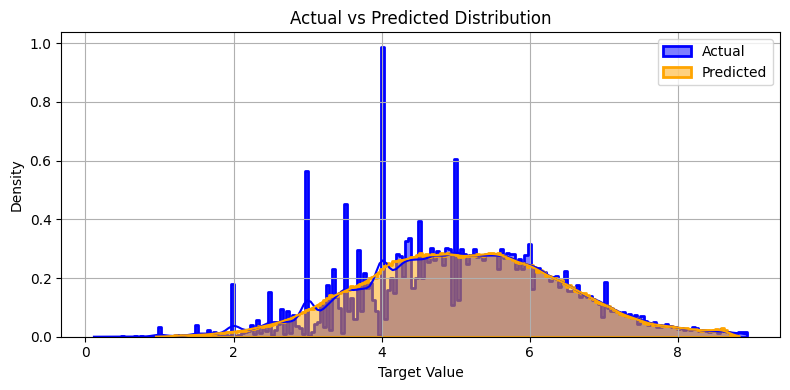

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(train_y, label="Actual", color="blue", kde=True, stat="density", element="step", linewidth=2)
sns.histplot(y_pred_clipped, label="Predicted", color="orange", kde=True, stat="density", element="step", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.xlabel("Target Value")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

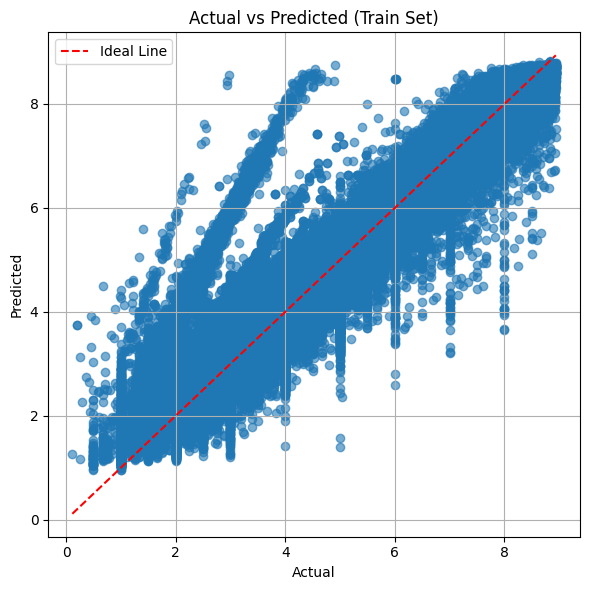

In [ ]:
min_val = min(train_y.min(), y_pred_clipped.min())
max_val = max(train_y.max(), y_pred_clipped.max())

plt.figure(figsize=(6, 6))
plt.scatter(train_y, y_pred_clipped, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
submission_ids = datamart[datamart['is_train'] == 0]['id']
X_test = datamart[datamart['is_train'] == 0].drop(columns=["id", "is_train", "Calories", "Calories_Per_Duration", "Calories_means", "Duration", "Z_Score"])
pred_per_minute = final_model.predict(X_test)

# (2) Duration 불러오기
durations = datamart[datamart['is_train'] == 0]['Duration'].values

# (3) 최종 칼로리 계산 (예측값 * Duration)
final_predictions = pred_per_minute * durations
predictions = np.maximum(final_predictions, 0)

submission = pd.DataFrame({
    "id": submission_ids,
    "Target": predictions
})


submission.to_csv("submission.csv", index=False)

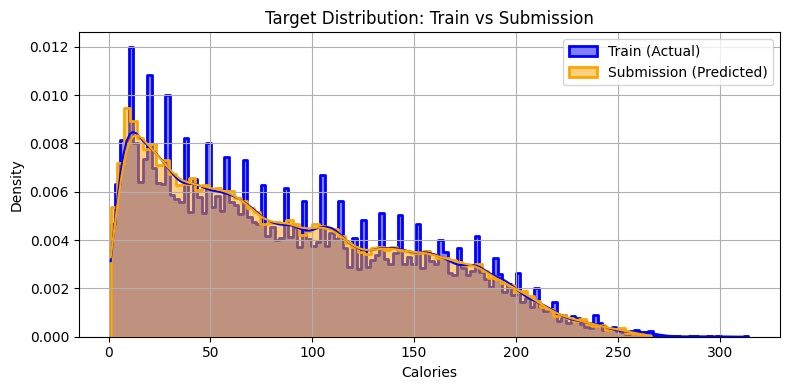

In [ ]:
plt.figure(figsize=(8, 4))

sns.histplot(train['Calories'], label="Train (Actual)", color="blue", kde=True, stat="density", element="step", linewidth=2)

sns.histplot(submission['Target'], label="Submission (Predicted)", color="orange", kde=True, stat="density", element="step", linewidth=2)

plt.title("Target Distribution: Train vs Submission")
plt.xlabel("Calories")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
predictions = {}
fitted_models = {}

# 사용 모델들
model_classes = {
    "LGBM": LGBMRegressor,
    "CatBoost": CatBoostRegressor,
    "XGBoost": XGBRegressor,
    "HGBR": HistGradientBoostingRegressor
}

# inference할 feature 셋
X_test = datamart[datamart["is_train"] == 0].drop(columns=["id", "is_train", "Calories", "Calories_Per_Duration", "Calories_means", "Duration","Z_Score"])

# 각 모델 학습 및 예측
for model_name, ModelClass in model_classes.items():
    print(f"📦 {model_name} 모델 학습 및 예측 중...")

    # 최적 파라미터로 모델 생성
    model = ModelClass(**results[model_name]['best_params'])

    # 학습
    model.fit(train_X, train_y)

    # 예측 저장
    predictions[model_name] = model.predict(X_test)
    fitted_models[model_name] = model

📦 LGBM 모델 학습 및 예측 중...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 746387, number of used features: 10
[LightGBM] [Info] Start training from score 5.105092
📦 CatBoost 모델 학습 및 예측 중...
0:	learn: 1.2693202	total: 57.3ms	remaining: 50.5s
1:	learn: 1.1895630	total: 115ms	remaining: 50.6s
2:	learn: 1.1161271	total: 172ms	remaining: 50.5s
3:	learn: 1.0486240	total: 227ms	remaining: 49.8s
4:	learn: 0.9858796	total: 282ms	remaining: 49.4s
5:	learn: 0.9279681	total: 336ms	remaining: 49.1s
6:	learn: 0.8745144	total: 390ms	remaining: 48.7s
7:	learn: 0.8247481	total: 442ms	remaining: 48.3s
8:	learn: 0.7796850	total: 505ms	remaining: 48.9s
9:	learn: 0.7382517	total: 559ms	remaining: 48.7s
10:	learn: 0.6995764	total: 611ms	remaining: 48.4s
11:	learn: 0.6648218	total: 669ms	remaining: 48.5s
12:	

In [ ]:
# RMSLE 역수 기반 가중치 계산
inverse_rmsle = {name: 1 / results[name]['best_value'] for name in results}
total = sum(inverse_rmsle.values())
weights = {k: v / total for k, v in inverse_rmsle.items()}

# 가중 앙상블
ensemble_preds_weighted = sum(weights[name] * predictions[name] for name in predictions)

In [ ]:
# Duration 가져오기
durations = datamart[datamart['is_train'] == 0]['Duration'].values

# 최종 예측 칼로리 계산
final_calories = ensemble_preds_weighted * durations

submission = pd.DataFrame({
    "id": datamart[datamart['is_train'] == 0]['id'].values,
    "Target": final_calories
})
submission.to_csv("ensemble_submission.csv", index=False)